### Demo of transforming a lat/lon location and plotting the location's spectral profile 

In [1]:
import matplotlib.pyplot as plt
from spectral.io import envi
import numpy as np
from pyproj import Proj
import os
from osgeo import gdal

In [2]:
data_file = 'ang20231109t130728_001_L2A_OE_main_27577724_RFL_ORT'
#coords = [-33.494364,	20.704742]
# Swapping this out for a scene that I've already downloaded
# Just picked a location within said scene
coords = [-34.331919,	18.462524]
coords

[-34.331919, 18.462524]

In [3]:
data_file
gdal_ds = gdal.Open(data_file)
proj_native = gdal_ds.GetProjection()
proj_native

'PROJCS["unnamed",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",21],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'

#### Geotransform
[GDAL Geotranform](https://gdal.org/tutorials/geotransforms_tut.html)

A geotransform is an affine transformation from the image coordinate space (row, column), also known as (pixel, line) to the georeferenced coordinate space (projected or geographic coordinates).

In [4]:
trans = gdal_ds.GetGeoTransform() # x_ul, x_px, x_rot, y_ul, y_rot, y_px
trans

(264948.18243014097, 4.9, 0.0, 6200109.09601481, 0.0, -4.9)

In [5]:
ds = envi.open(os.path.splitext(data_file)[0] + '.hdr')
ds

	Data Source:   '.\ang20231109t130728_001_L2A_OE_main_27577724_RFL_ORT'
	# Rows:            777
	# Samples:         645
	# Bands:           425
	Interleave:        BIL
	Quantization:  32 bits
	Data format:   float32

In [6]:
# add step to translate coordinates
# EPSG:32734 - WGS-84 / UTM zone 34S
# clean this up !!
from pyproj import Proj
p = Proj("EPSG:32734", preserve_units=False)
x,y = p(18.462524, -34.331919)
print(x)
print(y)
coords_UTM = [6198123.964575693, 266556.95619134826]

266556.95619134826
6198123.964575693


In [7]:
# NEED TO TRANSLATE CORRDINATES AND USE coords_UTM
# COPIED BELOW
# DELETE THIS
#x_px_offset = int(round((coords[1] - trans[0]) / trans[1]))
#y_px_offset = int(round((coords[0] - trans[3]) / trans[5]))

#print(x_px_offset, y_px_offset)

In [8]:
x_px_offset = int(round((coords_UTM[1] - trans[0]) / trans[1]))
y_px_offset = int(round((coords_UTM[0] - trans[3]) / trans[5]))

print(x_px_offset, y_px_offset)

328 405


In [9]:
offset_size = 1
data = ds.open_memmap(interleave='bip')[y_px_offset - 1: y_px_offset + 1, x_px_offset - 1: x_px_offset + 1, :]
data

memmap([[[-0.01      ,  0.00412263,  0.01015606, ...,  0.07826312,
           0.07825156, -0.01      ],
         [-0.01      , -0.00163075,  0.01063511, ...,  0.0719026 ,
           0.07175852, -0.01      ]],

        [[-0.01      ,  0.00702074,  0.00818069, ...,  0.05249596,
           0.05261677, -0.01      ],
         [-0.01      ,  0.00697051,  0.00858138, ...,  0.05006736,
           0.05000218, -0.01      ]]], dtype=float32)

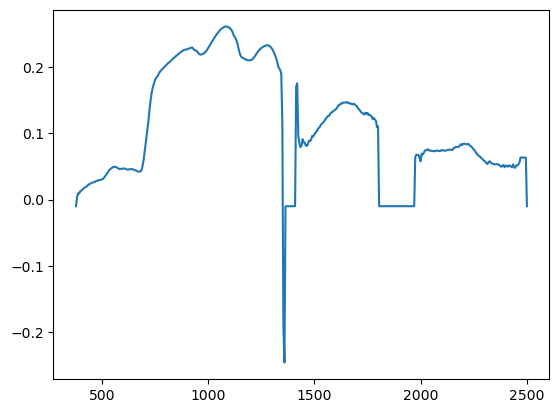

In [10]:
wl = np.array([float(x) for x in ds.metadata['wavelength']])

plt.plot(wl, np.mean(data, axis=(0, 1)))
# plot the average spectrum

In [11]:
# Define a list of wavelengths that are "bad" 

bblist = np.ones((425,))  # create a 1D array with values ones
# set tails and atmospheric window to zero
bblist[0:14] = 0        # tail
bblist[189:225] = 0     # atmospheric window
bblist[281:336] = 0     # atmospheric window
bblist[405:] = 0        # tail

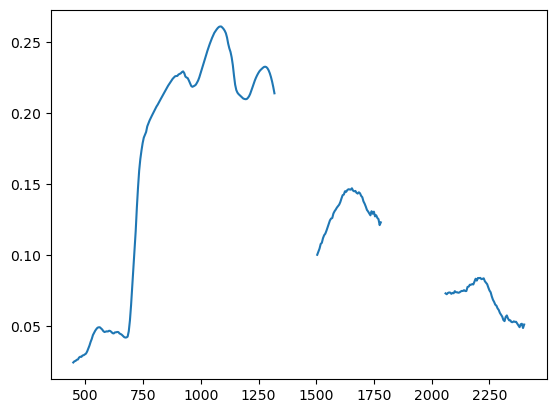

In [12]:
# Re-plot with the bad bands list and wavelengths applied
wl[bblist == 0] = np.nan    # vegeatation pixel
#SRB090[bblist == 0] = np.nan    # water pixel
plt.plot(wl, np.mean(data, axis=(0, 1)))